# Direct Collocation for Level Flight with Turns

This notebook explores using direct collocation to optimize the velocity along a trajectory in level flight.

Ingredients:
- A trajectory (we'll use Muhammad's code for this)
- Airplane dynamics
- Direct collocation, supplied by Drake

Let's start with a trajectory. We'll use this one:

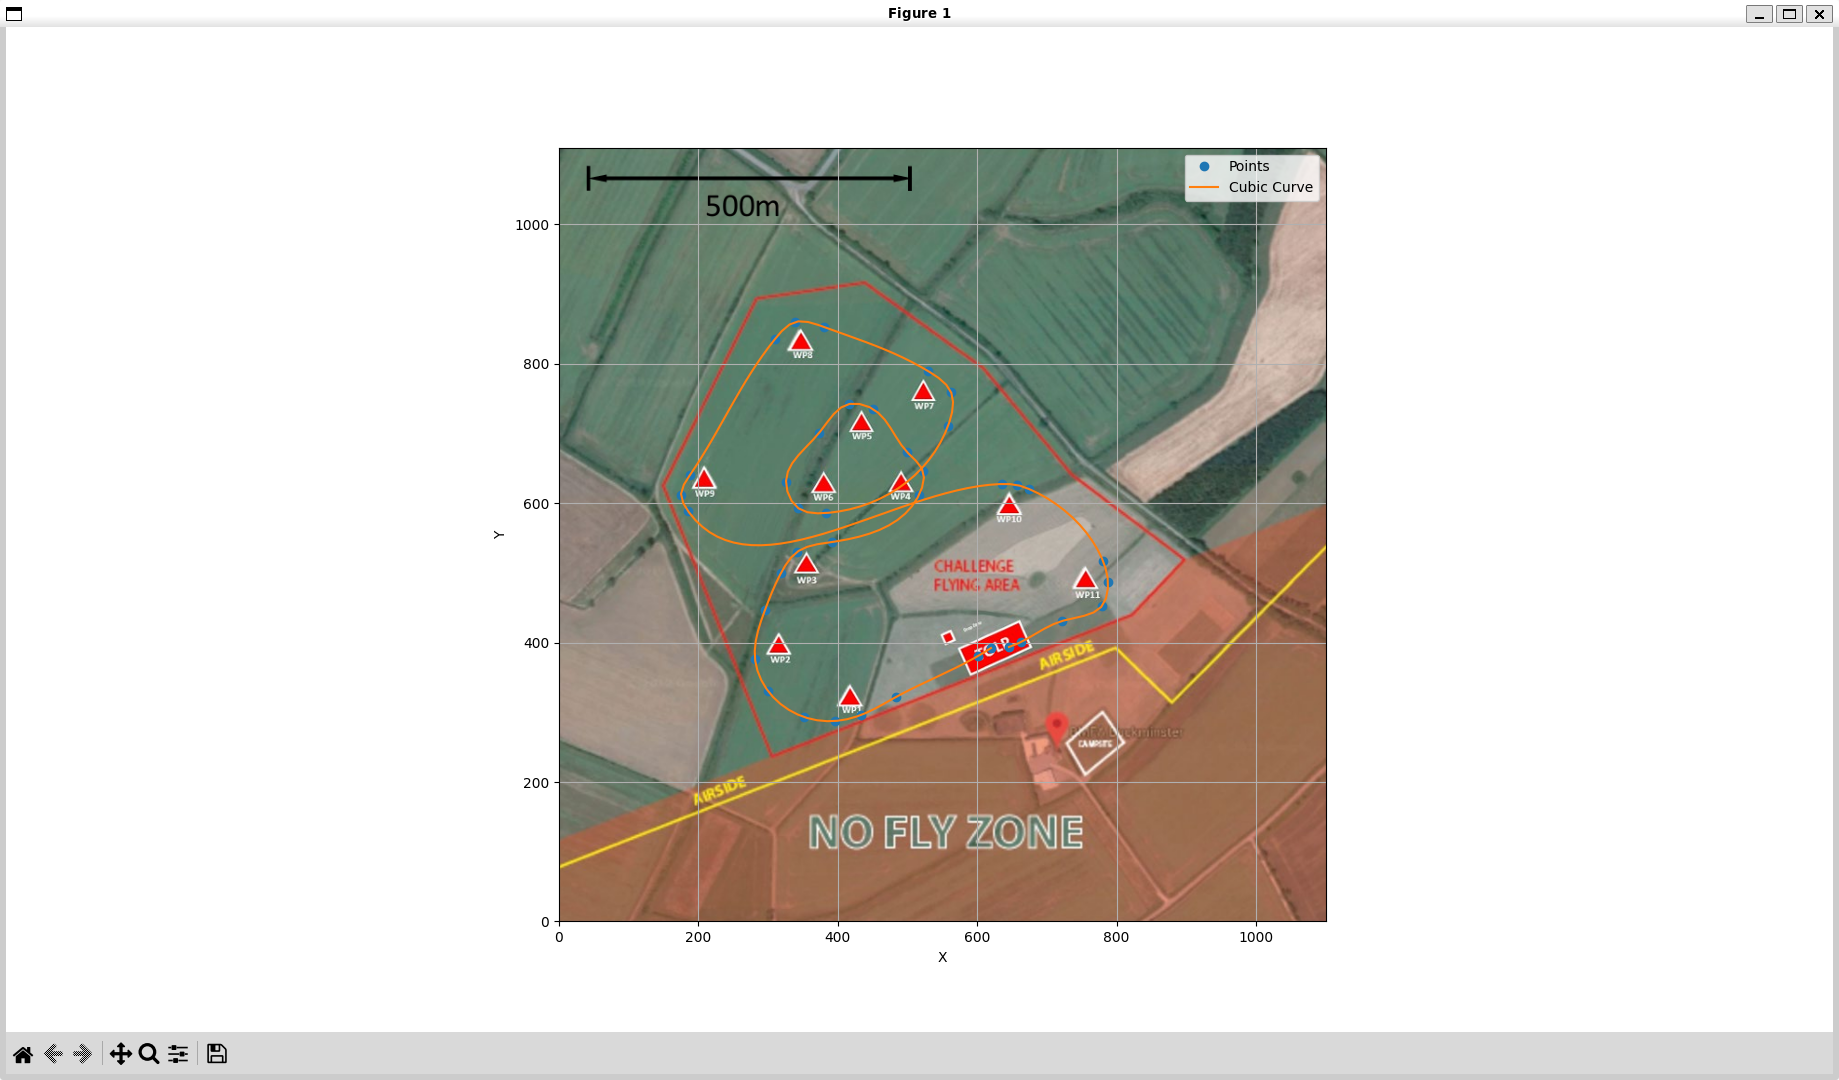

In [78]:
from test_spline import spline
print(f"Loaded spline of length {spline.length():.2f} m")

Loaded spline of length 2934.91 m


Our state of interest is *parametric distance* and *world-frame speed* along the path $\gamma$

$$
\mathbf x = \begin{bmatrix} t \\ V \end{bmatrix}
$$

To figure out the time derivative $\dot{\mathbf x}$, we can use the chain rule:

The distance $dx$ travelled by the path through an increment $d\xi$ is 

$$
\frac{dx}{d\xi} = \| \gamma'(\xi) \| =: \sigma(\xi)
$$

To travel the distance $dx$ requires time $dt = dx / V$ at velocity V. Then 

$$
d\xi = \frac{d\xi}{dx}V dt 
$$

or, in other words,

$$
\dot{\xi} = \frac{d\xi}{dt} = \frac{V}{\sigma}
$$

Then our equation of motion is

$$
\dot {\mathbf x}(\mathbf x, T) = \begin{bmatrix} V / \sigma \\ (T - D)/m \end{bmatrix}
$$

-------

Actually, the above equation of state doesn't allow you to easily optimize the amount of time taken to traverse the trajectory. We can fix that by reparameterizing with $\xi$ as the independent parameter, and the time in the state:

$$
\mathbf x = \begin{bmatrix}  t\\ V\end{bmatrix}
$$

with equation of state

$$
\mathbf x'(\xi, \mathbf x, T) = \frac{\sigma_\xi}{V} \begin{bmatrix} 1 \\ (T - D_\xi) / m \end{bmatrix} 
$$

Text(0, 0.5, "$\\|\\gamma'(\\xi)\\|$")

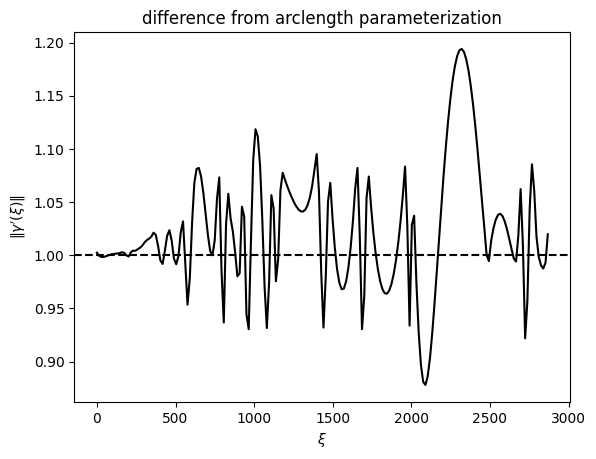

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import mpld3
mpld3.disable_notebook()
# ravel() is required because spline.start() returns a one-unit tuple 
# resulting in incorrect dimensions
t = np.linspace(spline.start(), spline.end(), 200).ravel()
plt.title("difference from arclength parameterization")
plt.plot(t, np.linalg.norm(spline.derivative(t), axis=1), color="black")
plt.axhline(1,linestyle="--", color="black")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\|\gamma'(\xi)\|$")

Text(0, 0.5, 'R')

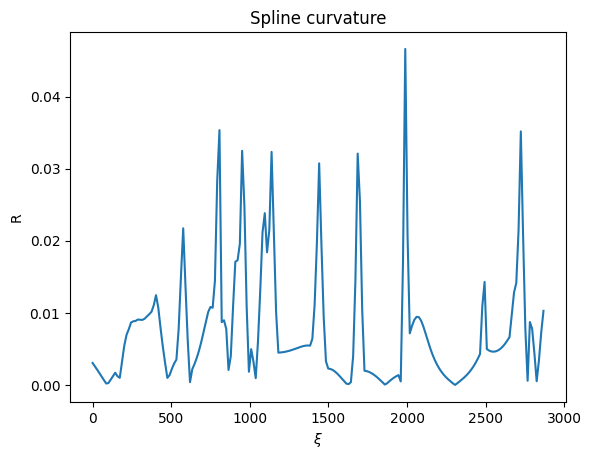

In [22]:
plt.title("Spline curvature")
# plt.plot(t, np.minimum(1/spline.curvature(t), 100 * np.ones_like(t)), color="black")
plt.plot(t, spline.curvature(t))
plt.xlabel(r"$\xi$")

plt.ylabel(r"R")

Text(0.5, 1.0, 'Discretization points and curvature comb')

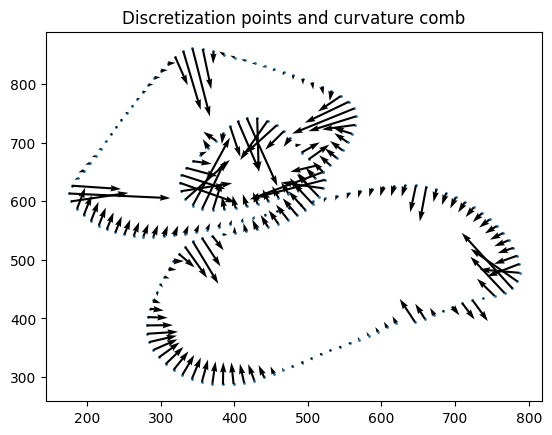

In [23]:
plt.scatter(spline(t)[:, 0], spline(t)[:, 1], s=1)
plt.quiver(spline(t)[:, 0], spline(t)[:, 1], spline.derivative(t, d=2)[:, 0], spline.derivative(t, d=2)[:,1])
plt.title("Discretization points and curvature comb")

# Notes from conversation AR

// How much more optimal is the optimal control?


Run tests with MPC -- check tracking vs offline computed trajectory

Check trajectory deviation against precomputed traj

Shorter - horizon MPC

Position vs control tracking against reference trajectory



In [88]:
class Airplane:
    def __init__(self, 
                 spline,
                 V0,
                 S, 
                 CD0, 
                 K, 
                 m,
                 rho=1.23, 
                 g=9.81):
        self.spline = spline # path
        self.x0 = np.array([0, V0])
        self.S = S
        self.CD0 = CD0
        self.K = K
        self.m = m # mass
        self.rho = rho
        self.g = g
    def stall_speed(self, CLmax):
        # 1/2 * rho * Vstall**2 * S * CL,max = m * g
        return np.sqrt(self.m * self.g / (1/2 * self.rho * self.S))

    def sigma(self, xi):
        return (self.spline.derivative(xi) @ self.spline.derivative(xi))**0.5
    def curvature(self, xi):
        return self.spline.curvature(xi)
    def CL(self, V, xi):
        curvature = self.curvature(xi)
        q = 0.5 * self.rho * V**2 
        L = (self.m**2 * (self.g**2 + V**4 * curvature**2))**0.5
        CL = L / (q * self.S)
        return CL
    def drag(self, V, xi):
        q = 0.5 * self.rho * V**2
        CL = self.CL(V, xi)
        CD = self.CD0 + self.K * CL**2
        return q * self.S * CD
    def bank_angle(self, V, xi):
        return np.arctan2(V**2 * self.curvature(xi), self.g)
        
    def continuous_dynamics(self, xi, x, T):
        sigma = self.sigma(xi) # parameter speed
        curvature = self.curvature(xi) # spline curvature
        t = x[0]
        V = x[1] # world-frame speed
        xi_dot = V / sigma
        V_dot = (T - self.drag(V, xi)) / self.m
        return np.concatenate([np.ones_like(V_dot), V_dot]) / xi_dot
    # dynamic residuals
    # if the residuals are zero, then the dynamics are satisfied by 
    # Backwards Euler integration
    def discrete_dynamic_residuals(self, xi, state, state_next, thrust, time_step):
        state_dot = self.continuous_dynamics(xi, state_next, thrust)
        residuals = state_next - state - time_step * state_dot
        return residuals

airplane = Airplane(
    spline = spline,
    V0 = 10,
    S = 1.92,
    CD0 = 0.03,
    K = 0.05,
    m = 10
)
print(airplane.stall_speed(CLmax = 1.2))

9.114782953679311


Now let's optimize a thrust trajectory.

In [93]:
from pydrake.all import MathematicalProgram, SnoptSolver


Vmax = 20 # m/s
CLmax = 1
Tmax = 20
phimax = np.radians(40)
xi_steps = 200
xis = np.linspace(airplane.spline.start(), airplane.spline.end(), xi_steps).ravel()

def make_prog(airplane, xis, Vmax, CLmax, Tmax, phimax):

    xi_steps = len(xis)
    dxis = np.diff(xis)

    # set up optimization problem
    prog = MathematicalProgram()
    # get state and thrust (symbolic vectors, N by n and N by m)
    state = prog.NewContinuousVariables(xi_steps, 2, "state")
    thrust = prog.NewContinuousVariables(xi_steps - 1, 1, "thrust")
    
    prog.AddConstraint(state[0][0] == 0)
    # prog.AddConstraint(state[0][1] == 10)
    
    # discretized dynamics
    for i, dxi in enumerate(dxis):
        residuals = airplane.discrete_dynamic_residuals(
            xis[i], state[i], state[i + 1], thrust[i], dxi
        )
        for residual in residuals:
            prog.AddConstraint(residual == 0)
        # minimum and maximum thrust
        prog.AddConstraint(thrust[i][0] >= 0)
        prog.AddConstraint(thrust[i][0]**2 <= Tmax**2)
    
    
    for i in range(xi_steps):
        # Maximum velocity
        prog.AddConstraint(state[i][1]**2 <= Vmax**2)
        # Minimum velocity (stall speed)
        # This constraint not necessary as the next constraint avoids stall at all times
        # prog.AddConstraint(state[i][1] >= airplane.stall_speed(CLmax))
        # Maximum CL
        prog.AddConstraint(airplane.CL(state[i][1], xis[i])**2 <= CLmax**2)
        # Maximum bank angle
        prog.AddConstraint(airplane.bank_angle(state[i][1], xis[i])**2 <= phimax**2)

    # cost linear in final time
    prog.AddCost(state[-1][0])

    # quadratic control cost
    # for i in range(xi_steps - 1):
    #     prog.AddCost(thrust[i][0]**2)
    
    def get_initial_guess(spline, xis):
        V = np.linalg.norm(spline.derivative(xis), axis=1) # V = sigma
        t = xis
        return np.array([t, V]).T

    # set initial guess
    prog.SetInitialGuess(state, get_initial_guess(spline, xis))
    return prog, state, thrust

prog, state, thrust = make_prog(airplane, xis, Vmax, CLmax, Tmax, phimax)

In [94]:
# solve mathematical program
def solve_prog(prog):
    solver = SnoptSolver()
    result = solver.Solve(prog)
    return result

result = solve_prog(prog)
assert result.is_success()

# retrieve optimal solution
thrust_opt = result.GetSolution(thrust)
state_opt = result.GetSolution(state)    
time_opt = state_opt[:, 0]
V_opt = state_opt[:, 1]
print(time_opt[-1])

155.29945941781966


Text(0, 0.5, 'Lift force')

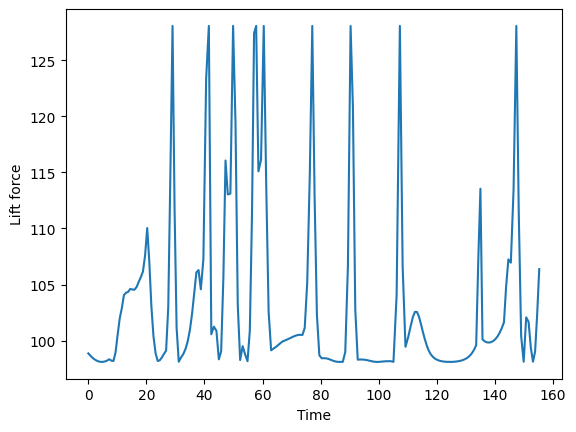

In [96]:
plt.plot(time_opt, airplane.CL(V_opt, xis) * airplane.S * 0.5 * airplane.rho * V_opt**2)
plt.xlabel("Time")
plt.ylabel("Lift force")

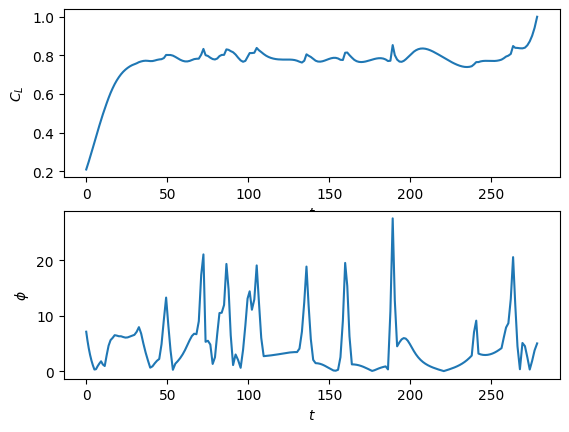

In [83]:
# plt.plot(xis[:-1], thrust_opt)
# plt.plot(xis, state_opt[:,1])
plt.subplot(211)
plt.ylabel("$C_L$")
plt.xlabel("$t$")
plt.plot(state_opt[:, 0], airplane.CL(V_opt, xis))
plt.subplot(212)
plt.ylabel(r"$\phi$")
plt.xlabel("$t$")
# plt.plot(time_opt, spline.curvature(xis))
plt.plot(state_opt[:, 0], np.degrees(airplane.bank_angle(state_opt[:, 1], xis)))

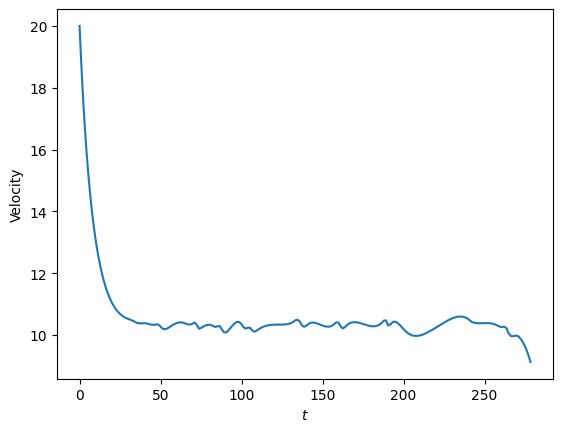

In [84]:
plt.xlabel("$t$")
plt.ylabel("Velocity")
plt.plot(time_opt, V_opt)
# plt.plot(time_opt, spline.curvature(xis) * 5e2)


Note that with the constraints, we can no longer go at full velocity through the whole course. 

Below we'll plot the optimal thrust vs time, with the curvature of the path overlaid on top. Note that, for the most part, the thrust is "bang-bang": when going into a turn, the motor is completely disabled (to slow down as quickly as possible) and when coming out of a turn the motor is set to maximum (to speed up as quickly as possible). This behavior is characteristic of minimal-time solutions with constrained control input.

Text(0.5, 1.0, 'Power vs time, $\\eta_{pr} = 0.8, \\eta_m = 0.8$')

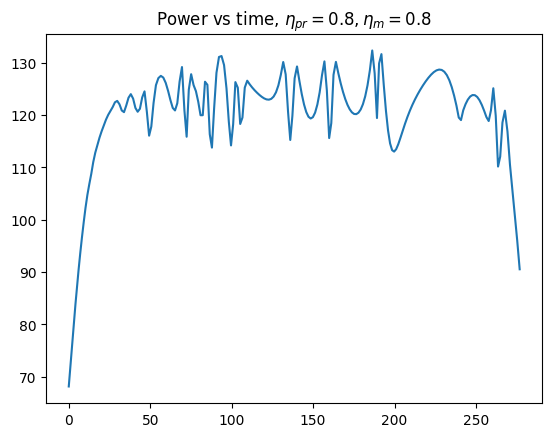

In [85]:
plt.plot(time_opt[:-1], thrust_opt * V_opt[:-1] * (1/ 0.8**2))
# plt.plot(time_opt[:-1], airplane.spline.curvature(xis)[:-1] * 5e2)
plt.title(r"Power vs time, $\eta_{pr} = 0.8, \eta_m = 0.8$")

In [87]:
from scipy.integrate import simpson
def get_energy_current(result, eta=0.8**2):
    # retrieve optimal solution
    thrust_opt = result.GetSolution(thrust)
    state_opt = result.GetSolution(state)    
    time_opt = state_opt[:, 0]
    V_opt = state_opt[:, 1]
    # eta = 0.8*0.8
    energy = simpson(thrust_opt * V_opt[:-1] / eta, x=time_opt[:-1])
    current = energy / 22 # V
    return energy, current

print("Energy usage for one lap", energy / 3600, "W-h")
print("Current usage", current / 3600, "A-h")

Energy usage for one lap 25.17956031629775 W-h
Current usage 1.144525468922625 A-h


In [77]:
print("CD0\tK\tS\tt\tE\tC")

for CD0 in [0.01, 0.02, 0.03, 0.04, 0.05]:
    for K in [0.02, 0.04, 0.06, 0.08, 0.10]:
        for S in np.arange(1.5,2.5,0.3):
            test_plane = Airplane(
                spline=spline, V0=0,
                S=S, CD0=CD0, K=K, m=10)
            prog, state, thrust = make_prog(test_plane, xis, Vmax, CLmax, Tmax, phimax)
            result = solve_prog(prog)
            if result.is_success():
                energy, current = get_energy_current(result)
                time = result.GetSolution(state)[:, 0]
                print("\t".join([f"{CD0:.2f}", f"{K:.2f}",
                          f"{S:.2f}", f"{time[-1]:.2f}", f"{energy/3600:.2f}",
                          f"{current/3600:.2f}"
                      ]))
                

CD0	K	S	t	E	C
0.01	0.02	1.50	160.10	4.86	0.22
0.01	0.02	1.80	159.26	5.52	0.25
0.01	0.02	2.10	158.48	6.31	0.29
0.01	0.02	2.40	157.76	7.09	0.32
0.01	0.04	1.50	158.19	5.80	0.26
0.01	0.04	2.10	157.39	6.99	0.32
0.01	0.04	2.40	156.96	7.69	0.35
0.01	0.06	1.50	156.90	6.68	0.30
0.01	0.06	1.80	156.81	7.11	0.32
0.01	0.06	2.10	156.60	7.65	0.35
0.01	0.06	2.40	156.34	8.25	0.38
0.01	0.08	1.50	156.04	7.53	0.34
0.01	0.08	1.80	156.09	7.84	0.36
0.01	0.08	2.40	155.87	8.83	0.40
0.01	0.10	1.50	155.46	8.41	0.38
0.01	0.10	1.80	155.57	8.58	0.39
0.01	0.10	2.10	155.57	8.92	0.41
0.01	0.10	2.40	155.51	9.42	0.43
0.02	0.02	1.50	156.18	9.25	0.42
0.02	0.02	1.80	155.62	10.84	0.49
0.02	0.02	2.10	155.23	12.48	0.57
0.02	0.02	2.40	155.01	14.14	0.64
0.02	0.04	1.50	155.53	10.16	0.46
0.02	0.04	2.10	155.01	13.11	0.60
0.02	0.04	2.40	154.94	14.71	0.67
0.02	0.06	1.50	155.12	10.99	0.50
0.02	0.06	1.80	154.98	12.29	0.56
0.02	0.06	2.10	154.89	13.72	0.62
0.02	0.06	2.40	154.90	15.24	0.69
0.02	0.08	1.50	154.89	11.82	0.54
0.02	0.08	1.80	

In [92]:
spline.length() / 20 # hard lower limit

146.74556103991688